In [ ]:
# !pip install gym

     ---------------------------------------- 0.0/721.7 kB ? eta -:--:--
     ------- ------------------------------ 143.4/721.7 kB 2.8 MB/s eta 0:00:01
     --------------------- ---------------- 409.6/721.7 kB 4.2 MB/s eta 0:00:01
     -------------------------------------  716.8/721.7 kB 5.7 MB/s eta 0:00:01
     -------------------------------------- 721.7/721.7 kB 4.1 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827740 sha256=1c682e0f7f89b894399a2e29902a883166aeddf23b244c7a1cbfc7e1757fd210
  Stored in directory: c:\users\arild\appdata\local\pip\cache\wheels\b9\22\6d\3e7b32d98451b4cd9d12417052affbeeeea012955d437da1da
Su


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import gym
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import os

In [2]:
DEFAULT_RANDOM_SEED = 2021

def seedBasic(seed=DEFAULT_RANDOM_SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

def seedEverything(seed=DEFAULT_RANDOM_SEED):
    seedBasic(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seedEverything(2021)

In [3]:
# ---------------------------
# Custom Environment
# ---------------------------
class TabularClassificationEnv(gym.Env):
    def __init__(self, df):
        super(TabularClassificationEnv, self).__init__()
        self.df = df.reset_index(drop=True)
        self.current_index = 0

        # Action space: two actions (0 and 1)
        self.action_space = gym.spaces.Discrete(2)
        # Observation space: features (assumes label is dropped)
        num_features = df.shape[1] - 1
        self.observation_space = gym.spaces.Box(
            low=-np.inf, high=np.inf, shape=(num_features,), dtype=np.float32)

    def reset(self):
        self.current_index = 0
        return self._get_observation()

    def step(self, action):
        if self.current_index >= len(self.df):
            return self._get_observation(), 0.0, True, {}

        # Retrieve the true label; assumes column name 'label'
        true_label = self.df.iloc[self.current_index]['label']

        # Modified reward structure:
        # If the sample is positive (label == 1), reward correctly.
        # Penalize misclassification more severely.
        if action == true_label:
            reward = 3.0 if true_label == 1 else 0.5
        else:
            reward = -3.0 if true_label == 1 else -1.0

        self.current_index += 1
        done = self.current_index >= len(self.df)
        if done:
            return self._get_observation(), reward, done, {}
        else:
            return self._get_observation(), reward, done, {}

    def _get_observation(self):
        if self.current_index < len(self.df):
            row = self.df.iloc[self.current_index]
            if 'label' in self.df.columns:
                obs = row.drop('label').values.astype(np.float32)
            else:
                obs = row.values[:-1].astype(np.float32)
            return obs
        else:
            return np.zeros(self.observation_space.shape, dtype=np.float32)

Setting environment for agent

In [4]:
# ---------------------------
# Q-Network Definition
# ---------------------------
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_sizes=(32, 32)):
        super(QNetwork, self).__init__()
        layers = []
        in_dim = input_dim
        for h in hidden_sizes:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.ReLU())
            in_dim = h
        layers.append(nn.Linear(in_dim, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [5]:
# ---------------------------
# DQN Agent
# ---------------------------
class DQNAgent:
    def __init__(self, obs_dim, action_dim, hidden_sizes=(32, 32), lr=1e-3,
                 gamma=0.99, epsilon=0.1, device='cpu'):
        self.q_net = QNetwork(obs_dim, action_dim, hidden_sizes).to(device)
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)
        self.gamma = gamma
        self.epsilon = epsilon
        self.action_dim = action_dim
        self.device = device

    def select_action(self, state):
        # Epsilon-greedy action selection
        if random.random() < self.epsilon:
            return random.randint(0, self.action_dim - 1)
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_values = self.q_net(state_tensor)
        return q_values.argmax().item()

    def train_step(self, batch):
        # Unpack a batch of transitions
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.FloatTensor(np.array(states)).to(self.device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        next_states = torch.FloatTensor(np.array(next_states)).to(self.device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(self.device)

        # Compute current Q-values for taken actions
        q_values = self.q_net(states).gather(1, actions)
        # Compute the next state's maximum Q-value
        next_q_values = self.q_net(next_states).max(1)[0].unsqueeze(1)
        # Compute TD target
        target = rewards + self.gamma * next_q_values * (1 - dones)
        loss = F.mse_loss(q_values, target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

In [6]:
# ---------------------------
# Simple Replay Buffer
# ---------------------------
class ReplayBuffer:
    def __init__(self):
        self.buffer = []

    def add(self, transition):
        self.buffer.append(transition)

    def clear(self):
        self.buffer = []

    def sample_all(self):
        return self.buffer.copy()

    def __len__(self):
        return len(self.buffer)

In [7]:
# ---------------------------
# Training Function
# ---------------------------
def train_agent(agent, env, replay_buffer, num_iterations=1000, batch_size=32, verbose=True):
    state = env.reset()
    print("Training...")
    for i in range(num_iterations):
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)
        replay_buffer.add((state, action, reward, next_state, float(done)))
        state = next_state
        if done:
            state = env.reset()

        # Train only if we have enough samples in the buffer
        if len(replay_buffer) >= batch_size:
            # Sample a mini-batch randomly from the replay buffer
            batch = random.sample(replay_buffer.buffer, batch_size)
            loss = agent.train_step(batch)
            if i % 100 == 0 and verbose:
                  print(f"Iteration {i}, Loss: {loss}")


In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

def test_agent(agent, env):
    # Set epsilon to 0 for deterministic behavior during testing
    original_epsilon = agent.epsilon
    agent.epsilon = 0.0

    state = env.reset()
    total_reward = 0
    correct_predictions = 0
    total_predictions = 0
    y_true = []
    y_pred = []
    done = False

    while not done:
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)
        total_reward += reward

        # After calling step, the environment index is incremented.
        # This allows us to get the true label corresponding to the state from which the action was taken.
        idx = env.current_index - 1 if env.current_index > 0 else 0
        true_label = env.df.iloc[idx]['label']

        y_true.append(true_label)
        y_pred.append(action)

        if action == true_label:
            correct_predictions += 1
        total_predictions += 1

        state = next_state

    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0

    precision = precision_score(y_true, y_pred, pos_label=1)
    recall = recall_score(y_true, y_pred, pos_label=1)
    f1 = f1_score(y_true, y_pred, pos_label=1)
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.ravel()
    false_positive_rate = FP / (FP + TN) if (FP + TN) > 0 else 0.0

    print(f"Total Reward: {total_reward}, Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"False Positive Rate: {false_positive_rate}")

    # Restore the original epsilon
    agent.epsilon = original_epsilon


Above function is used by the testing agent

In [9]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load your DataFrame
df = pd.read_csv('combined_train_df.csv')

In [10]:
df['label'] = df['label'].apply(lambda x: 0 if x == 'BENIGN' else 1)
df.drop('Unnamed: 0',axis=1,inplace=True)

In [11]:
# Split into training and testing sets (67% train, 33% test)
X = df.drop('label',axis=1)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=DEFAULT_RANDOM_SEED)

scaler = joblib.load("scaler.pkl")

features = scaler.feature_names_in_

X_train = X_train[features]
X_test = X_test[features]


X_train_scaled = pd.DataFrame(
    scaler.transform(X_train),
    columns=scaler.feature_names_in_,
    index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=scaler.feature_names_in_,
    index=X_test.index
)

train_df = pd.concat([X_train_scaled, y_train], axis=1)
test_df = pd.concat([X_test_scaled, y_test], axis=1)

In [12]:
train_df.head(10)

,ack flag count,act_data_pkt_fwd,active max,active mean,active min,active std,average packet size,avg bwd segment size,avg fwd segment size,bwd avg bulk rate,...,subflow bwd packets,subflow fwd bytes,subflow fwd packets,syn flag count,total backward packets,total fwd packets,total length of bwd packets,total length of fwd packets,urg flag count,label
7289,1.473529,-0.009832,-0.178309,-0.152852,-0.124764,-0.123988,-0.617415,-0.542085,-0.332072,0.0,...,-0.011065,-0.073231,-0.011844,-0.231803,-0.010968,-0.011828,-0.007983,-0.072842,-0.337576,0
133052,-0.678643,-0.008027,-0.178309,-0.152852,-0.124764,-0.123988,-0.433243,-0.410934,-0.178627,0.0,...,-0.009989,-0.066866,-0.011844,-0.231803,-0.009891,-0.011828,-0.007900,-0.066474,-0.337576,0
94049,-0.678643,-0.008027,-0.178309,-0.152852,-0.124764,-0.123988,-0.363651,-0.360608,-0.122364,0.0,...,-0.009989,-0.064532,-0.011844,-0.231803,-0.009891,-0.011828,-0.007868,-0.064140,-0.337576,0
41614,-0.678643,-0.008027,-0.178309,-0.152852,-0.124764,-0.123988,-0.215329,-0.197432,-0.127479,0.0,...,-0.009989,-0.064744,-0.011844,-0.231803,-0.009891,-0.011828,-0.007765,-0.064352,-0.337576,0
173143,1.473529,0.210355,-0.178309,-0.152553,-0.124746,-0.123988,3.872388,3.957707,-0.278098,0.0,...,0.203205,1.928719,0.167679,-0.231803,0.051483,0.167695,0.101976,1.991995,-0.337576,1
144436,1.473529,-0.006222,-0.178309,-0.152852,-0.124764,-0.123988,-0.571489,-0.542085,-0.258759,0.0,...,-0.012142,-0.068669,-0.010384,-0.231803,-0.012045,-0.010368,-0.007983,-0.068278,-0.337576,0
19962,-0.678643,0.024459,-0.116146,-0.128526,-0.104633,-0.083227,-0.229018,-0.161171,-0.139499,0.0,...,0.007239,0.006648,0.014428,-0.231803,0.007337,0.014444,-0.005810,0.007069,-0.337576,0
52900,1.473529,-0.008027,-0.178309,-0.152852,-0.124764,-0.123988,-0.548058,-0.532935,-0.237448,0.0,...,-0.011065,-0.069306,-0.011844,4.314009,-0.010968,-0.011828,-0.007981,-0.068915,-0.337576,0
121607,-0.678643,-0.000808,-0.084983,-0.105810,-0.104613,-0.008684,-0.319190,-0.382340,0.217132,0.0,...,-0.003528,0.017892,-0.003086,-0.231803,-0.003431,-0.003070,-0.007578,0.018318,-0.337576,0
86452,1.473529,-0.009832,-0.178309,-0.152852,-0.124764,-0.123988,-0.617415,-0.542085,-0.332072,0.0,...,-0.011065,-0.073231,-0.013303,-0.231803,-0.010968,-0.013287,-0.007983,-0.072842,2.962292,0


In [13]:
# Create training and testing environments
train_env = TabularClassificationEnv(train_df)
test_env = TabularClassificationEnv(test_df)

# Get observation and action dimensions from the training environment
obs_dim = train_env.observation_space.shape[0]
action_dim = train_env.action_space.n

# Instantiate the DQN Agent and Replay Buffer
agent = DQNAgent(obs_dim, action_dim, hidden_sizes=(128, 128), lr=0.001,
                 gamma=0.99, epsilon=0.1, device='cpu')
replay_buffer = ReplayBuffer()

In [14]:
# Train the agent on the training environment
train_agent(agent, train_env, replay_buffer, num_iterations=4000, verbose=False)

# Test the agent on the testing environment
test_agent(agent, test_env)

Training...
Total Reward: 50467.5, Accuracy: 0.9275217158547326
Precision: 0.7711518186610438
Recall: 0.9417397601995655
F1 Score: 0.8479513096402564
False Positive Rate: 0.076363236587511


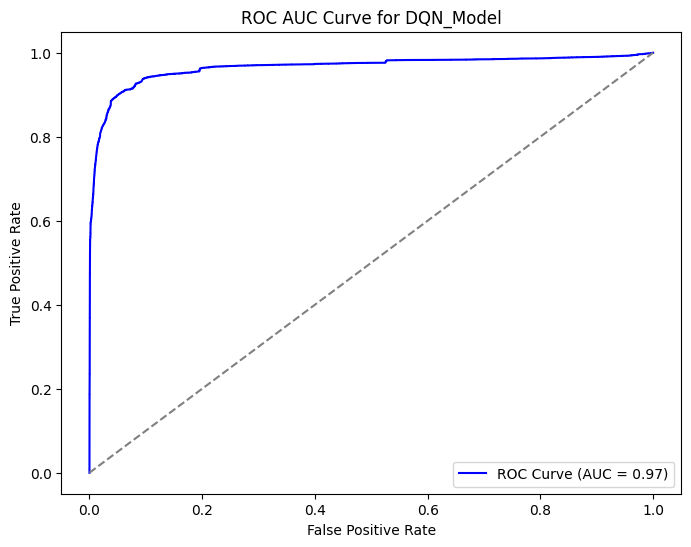

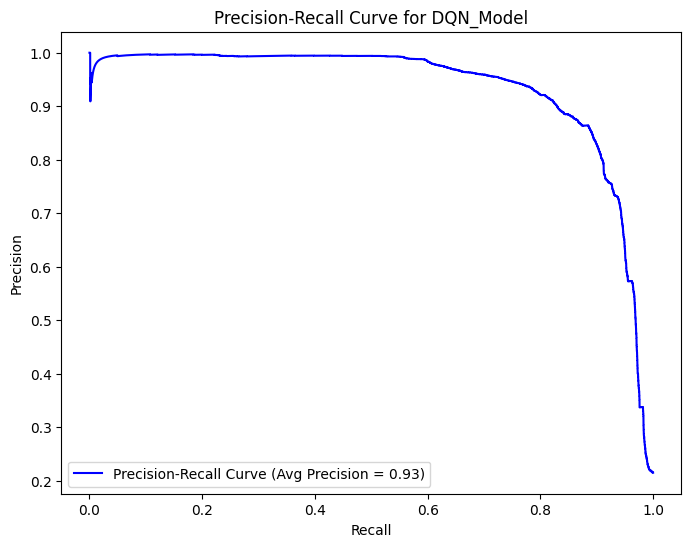

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score


model_name = "DQN_Model"

# Gather a 'score' for each sample in test_df by using Q-value for action=1
y_true = []
scores = []  # We'll treat Q-value(action=1) as the confidence for label=1

# Force deterministic (no epsilon)
agent.epsilon = 0.0
with torch.no_grad():
    for i in range(len(test_df)):
        row = test_df.iloc[i]
        label = row['label']
        # Extract features
        state = row.drop('label').values.astype(np.float32)

        # Get Q-values
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        q_values = agent.q_net(state_tensor)

        # Score = Q-value for action=1
        score_for_class1 = q_values[0, 1].item()

        y_true.append(label)
        scores.append(score_for_class1)

y_true = np.array(y_true)
scores = np.array(scores)

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, scores)
auc_score = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC AUC Curve for {model_name}')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, scores)
avg_precision = average_precision_score(y_true, scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue',
         label=f'Precision-Recall Curve (Avg Precision = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve for {model_name}')
plt.legend(loc='lower left')
plt.show()

Plot to see whether model is overfitting or not

In [16]:
torch.save(agent.q_net.state_dict(), "dqn_model.pth")
print("Model saved as dqn_model.pth")

Model saved as dqn_model.pth


Storing weights which is called to the online learning part